# Анализ влияния флэшмоба на активность пользователей в социальной сети с использованием библиотеки CausalImpact

Команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2024-05-17 по 2024-05-23.  
**Задача:** оценить эффективность этого мероприятия.

### Шаг 1. Определим метрики, которые должны измениться во время флэшмоба
**1. Количество новых постов.** Флешмоб подразумевает размещение нового интересного поста, значит кол-во постов должно увеличится. 
**2. Количество просмотров на пользователя.** Посты публикуются с хэштегом, по которому пользователь может перейти к похожим постам, и остаться в ленте дольше.  
**3. Количество просмотров на пост.** Посты публикуются с хэштегом, по которому пользователь может перейти к похожим постам, значит конкурсные посты должны набирать больше просмотров.  
**4. Количество лайков на пост.** Конкурс агитирует ставить лайки, чтобы выиграть и получить приз, поэтому число лайков должно увеличится.   
**5. DAU.** Участники флешмоба будут заинтересованы отслеживать прогресс своих постов, скорее всего будут заходить в приложение чаще, чем обычно.


### Шаг 2. Проверим, реально ли эти метрики изменились, используя CausalImpact

Используем библиотеку **CausalImpact** для анализа данных, разделяя их на периоды до и после маркетинговой кампании. Алгоритм вычисляет контрфактический сценарий — что бы произошло с метриками, если бы кампании не было, и сравнивает это с фактическими показателями после её проведения.

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_probability as tfp
import causalimpact
from causalimpact import CausalImpact
tf.get_logger().setLevel('ERROR')

2024-09-07 19:15:08.690815: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 19:15:08.888494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 19:15:08.889360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 19:15:10.085112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Подключаемся к схеме данных ленты новостей
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20240520',
    'user':'student',
    'password':'dpo_python_2020'
}

#### Метрика №1: Количество новых постов

In [3]:
# Рассчитаем кол-во новых постов
q_post = """
select count(post_id) as post_qty, dt
from 
(select post_id, min(toDate(time)) as dt
from simulator_20240520.feed_actions
group by post_id) 
group by dt
having dt between '2024-04-12' and '2024-05-23'
"""

df_post = ph.read_clickhouse(q_post, connection=connection)

In [4]:
df_post.head()

,post_qty,dt
0,92,2024-04-12
1,61,2024-04-13
2,92,2024-04-14
3,77,2024-04-15
4,79,2024-04-16


<Axes: xlabel='dt', ylabel='post_qty'>

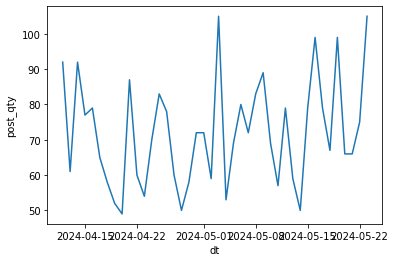

In [5]:
sns.lineplot(df_post, x="dt", y="post_qty")

In [6]:
# Изменим тип даты на строку и установим дату как индекс
df_post['dt'] = df_post['dt'].astype(str)
df_post = df_post.set_index('dt')

In [7]:
df_post.head()

,post_qty
dt,
2024-04-12,92
2024-04-13,61
2024-04-14,92
2024-04-15,77
2024-04-16,79


In [8]:
# Построим модель для метрики post_qty
trend_component = tfp.sts.LocalLinearTrend(df_post)
impact_post = CausalImpact(data=df_post, #данные
                      pre_period=["2024-04-12", "2024-05-16"], #период до события
                      post_period=["2024-05-17", "2024-05-23"], #период после события
                      model_args={"nseasons":7}) #сезонность по дням недели

2024-09-07 19:15:13.244068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-09-07 19:15:13.244282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-09-07 19:15:13.251518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-09-07 19:15:13.251688: I tens

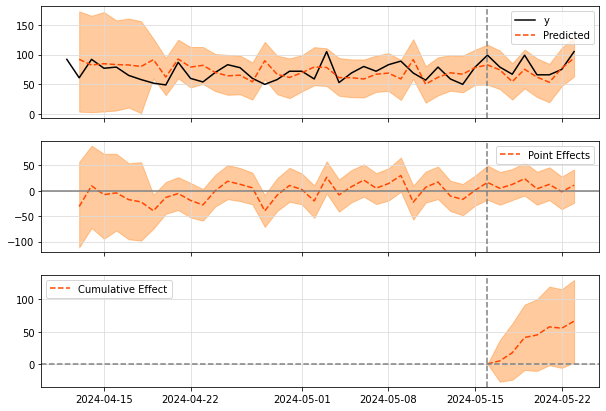

In [9]:
impact_post.plot()

In [10]:
print(impact_post.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.57              557.0
Prediction (s.d.)         70.11 (4.28)       490.74 (29.96)
95% CI                    [61.97, 78.75]     [433.79, 551.24]

Absolute effect (s.d.)    9.47 (4.28)        66.26 (29.96)
95% CI                    [0.82, 17.6]       [5.76, 123.21]

Relative effect (s.d.)    13.5% (6.11%)      13.5% (6.11%)
95% CI                    [1.17%, 25.11%]    [1.17%, 25.11%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.5%

For more details run the command: print(impact.summary('report'))


In [11]:
print(impact_post.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 79.57. By contrast, in the absence of an
intervention, we would have expected an average response of 70.11.
The 95% interval of this counterfactual prediction is [61.97, 78.75].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 9.47 with a 95% interval of
[0.82, 17.6]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 557.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 490.74. The 95% interval of this prediction is [433.79, 551.24].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s

#### Вывод:   
Без флешмоба среднее значение новых постов прогнозируется около 70, в то время как в действительности во время флешмоба среднее значение было около 79. Вычитая прогнозное среднее значение из фактического получаем причинно-следственный эффект 9. В относительных значениях переменная количества новых постов показала увеличение на ~13%.  
Полученный эффект, наблюдаемый в период флешмоба, является статистически значимым, p-value < 0.05. Вероятность получения такого эффекта случайным образом очень мала.

Но доверительный интервал полученных прогнозных значений очень широк, фактическое значение количества новых постов колеблется в рамках доверительного интервала, однозначно заявить о том, что метрика улучшилась именно в ходе флешмоба, не стоит. Проверим остальные метрики.

#### Метрика №2: Количество просмотров на пользователя

In [12]:
# Рассчитаем метрику view_per_user
q_view_per_user = """
select countIf(action='view')/countDistinct(user_id) as view_per_user, toDate(time) as dt
from simulator_20240520.feed_actions
where dt between '2024-04-12' and '2024-05-23'
group by dt
"""

df_view_per_user = ph.read_clickhouse(q_view_per_user, connection=connection)

In [13]:
df_view_per_user.head()

,view_per_user,dt
0,37.826380,2024-04-12
1,39.371045,2024-04-13
2,35.586324,2024-04-14
3,42.314986,2024-04-15
4,38.522707,2024-04-16


<Axes: xlabel='dt', ylabel='view_per_user'>

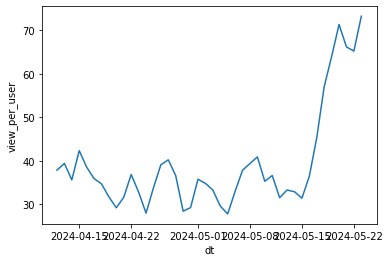

In [14]:
sns.lineplot(df_view_per_user, x="dt", y="view_per_user")

In [15]:
# Изменим тип даты на строку и установим дату как индекс
df_view_per_user['dt'] = df_view_per_user['dt'].astype(str)
df_view_per_user = df_view_per_user.set_index('dt')

In [16]:
df_view_per_user.head()

,view_per_user
dt,
2024-04-12,37.826380
2024-04-13,39.371045
2024-04-14,35.586324
2024-04-15,42.314986
2024-04-16,38.522707


In [17]:
# Построим модель для метрики DAU
impact_view_per_user = CausalImpact(data=df_view_per_user, #данные
                      pre_period=["2024-04-12", "2024-05-16"], #период до события
                      post_period=["2024-05-17", "2024-05-23"], #период после события
                      model_args={"nseasons":7}) #сезонность по дням недели

2024-09-07 19:15:29.570483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:15:29.586189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:15:30.164509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:

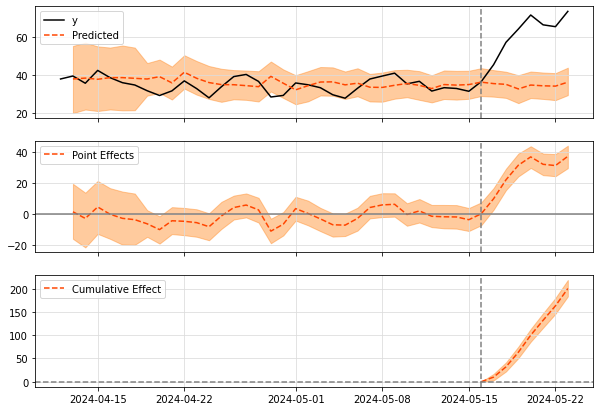

In [18]:
impact_view_per_user.plot()

In [19]:
print(impact_view_per_user.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    63.21              442.5
Prediction (s.d.)         34.59 (1.29)       242.13 (9.06)
95% CI                    [31.93, 37.01]     [223.53, 259.04]

Absolute effect (s.d.)    28.62 (1.29)       200.36 (9.06)
95% CI                    [26.21, 31.28]     [183.45, 218.97]

Relative effect (s.d.)    82.75% (3.74%)     82.75% (3.74%)
95% CI                    [75.77%, 90.43%]   [75.77%, 90.43%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [20]:
print(impact_view_per_user.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 63.21. By contrast, in the absence of an
intervention, we would have expected an average response of 34.59.
The 95% interval of this counterfactual prediction is [31.93, 37.01].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 28.62 with a 95% interval of
[26.21, 31.28]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 442.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 242.13. The 95% interval of this prediction is [223.53, 259.04].


The above results are given in terms of absolute numbers. In relative
terms, the response variabl

#### Вывод:   
Без флешмоба среднее значение просмотров на пользователя прогнозируется около 34, в то время как в действительности во время флешмоба среднее значение было около 63. Вычитая прогнозное среднее значение из фактического получаем причинно-следственный эффект 28. В относительных значениях переменная количества новых постов показала увеличение на ~83%.  
Полученный эффект, наблюдаемый в период флешмоба, является статистически значимым, p-value = 0.00. Вероятность получения такого эффекта случайным образом очень мала.

Доверительный интервал полученных значений довольно узкий, значит значения не слишком волатильны и плюс-минус точны.
На графике видна значительная разница между прогнозными и фактическими значениями, влияние флешмоба заметно.

#### Метрика №3: Количество просмотров на пост

In [21]:
# Рассчитаем кол-во просмотров на пост
q_view_per_post = """
select countIf(action='view')/countDistinct(post_id) as view_per_post, toDate(time) as dt
from simulator_20240520.feed_actions
where dt between '2024-04-12' and '2024-05-23'
group by dt
"""

df_view_per_post = ph.read_clickhouse(q_view_per_post, connection=connection)

In [22]:
df_view_per_post.head()

,view_per_post,dt
0,777.189076,2024-04-12
1,1023.995575,2024-04-13
2,1020.995763,2024-04-14
3,1448.343750,2024-04-15
4,1274.200000,2024-04-16


<Axes: xlabel='dt', ylabel='view_per_post'>

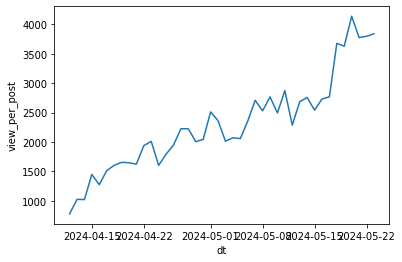

In [23]:
sns.lineplot(df_view_per_post, x="dt", y="view_per_post")

In [24]:
# Изменим тип даты на строку и установим дату как индекс
df_view_per_post['dt'] = df_view_per_post['dt'].astype(str)
df_view_per_post = df_view_per_post.set_index('dt')

In [25]:
df_view_per_post.head()

,view_per_post
dt,
2024-04-12,777.189076
2024-04-13,1023.995575
2024-04-14,1020.995763
2024-04-15,1448.343750
2024-04-16,1274.200000


In [26]:
# Построим модель для метрики view_per_post
impact_view_per_post = CausalImpact(data=df_view_per_post, #данные
                      pre_period=["2024-04-12", "2024-05-16"], #период до события
                      post_period=["2024-05-17", "2024-05-23"], #период после события
                      model_args={"nseasons":7}) #сезонность по дням недели

2024-09-07 19:15:45.480322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:15:45.569779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:15:46.076340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:

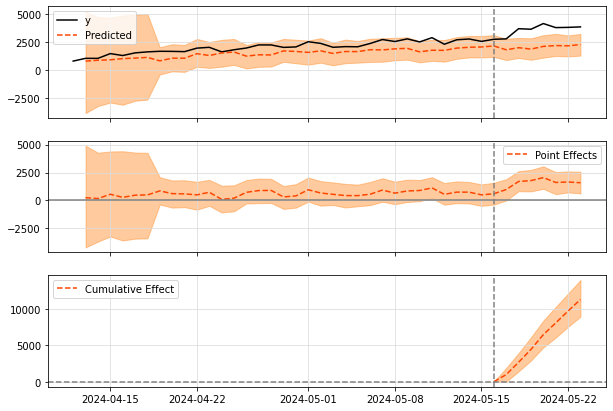

In [27]:
impact_view_per_post.plot()

In [28]:
print(impact_view_per_post.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3658.5             25609.52
Prediction (s.d.)         2038.92 (182.45)   14272.43 (1277.15)
95% CI                    [1663.69, 2378.88] [11645.86, 16652.18]

Absolute effect (s.d.)    1619.58 (182.45)   11337.09 (1277.15)
95% CI                    [1279.62, 1994.81] [8957.34, 13963.66]

Relative effect (s.d.)    79.43% (8.95%)     79.43% (8.95%)
95% CI                    [62.76%, 97.84%]   [62.76%, 97.84%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [29]:
print(impact_view_per_post.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3658.5. By contrast, in the absence of an
intervention, we would have expected an average response of 2038.92.
The 95% interval of this counterfactual prediction is [1663.69, 2378.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1619.58 with a 95% interval of
[1279.62, 1994.81]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 25609.52.
By contrast, had the intervention not taken place, we would have expected
a sum of 14272.43. The 95% interval of this prediction is [11645.86, 16652.18].


The above results are given in terms of absolute numbers. In relative
terms

#### Вывод:   
Без флешмоба среднее значение просмотров на пост прогнозируется около 2000, в то время как в действительности во время флешмоба среднее значение было около 3600. Вычитая прогнозное среднее значение из фактического получаем причинно-следственный эффект 1600. В относительных значениях переменная количества новых постов показала увеличение на ~80%.  
Полученный эффект, наблюдаемый в период флешмоба, является статистически значимым, p-value = 0.00. Вероятность получения такого эффекта случайным образом очень мала.

Метрика довольно сильно коррелирует с предыдущей, поэтому выводы те же: влияние флешмоба заметно.

#### Метрика №4: Количество лайков на пост

In [30]:
# Рассчитаем кол-во лайков на пост
q_like_post = """
select count(action)/countDistinct(post_id) as like_per_post, toDate(time) as dt
from simulator_20240520.feed_actions
where action = 'like' and dt between '2024-04-12' and '2024-05-23'
group by dt
"""

df_like_post = ph.read_clickhouse(q_like_post, connection=connection)

In [31]:
df_like_post.head()

,like_per_post,dt
0,166.389381,2024-04-12
1,207.659193,2024-04-13
2,214.221239,2024-04-14
3,294.500000,2024-04-15
4,261.571429,2024-04-16


<Axes: xlabel='dt', ylabel='like_per_post'>

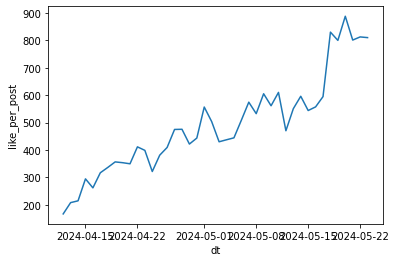

In [32]:
sns.lineplot(df_like_post, x="dt", y="like_per_post")

In [33]:
# Изменим тип даты на строку
df_like_post['dt'] = df_like_post['dt'].astype(str)
# Установим дату как индекс 
df_like_post = df_like_post.set_index('dt')

In [34]:
# Построим модель для метрики like_per_post
impact_like_post = CausalImpact(data=df_like_post, #данные
                      pre_period=["2024-04-12", "2024-05-16"], #период до события
                      post_period=["2024-05-17", "2024-05-23"], #период после события
                      model_args={"nseasons":7}) #сезонность по дням недели

2024-09-07 19:16:01.576603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:16:01.668530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:16:02.184252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:

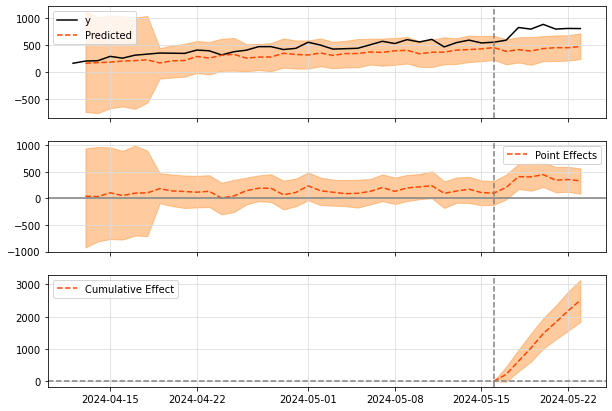

In [35]:
impact_like_post.plot()

In [36]:
print(impact_like_post.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    791.37             5539.61
Prediction (s.d.)         432.8 (44.48)      3029.62 (311.33)
95% CI                    [342.72, 517.06]   [2399.04, 3619.41]

Absolute effect (s.d.)    358.57 (44.48)     2510.0 (311.33)
95% CI                    [274.31, 448.65]   [1920.2, 3140.57]

Relative effect (s.d.)    82.85% (10.28%)    82.85% (10.28%)
95% CI                    [63.38%, 103.66%]  [63.38%, 103.66%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [37]:
print(impact_like_post.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 791.37. By contrast, in the absence of an
intervention, we would have expected an average response of 432.8.
The 95% interval of this counterfactual prediction is [342.72, 517.06].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 358.57 with a 95% interval of
[274.31, 448.65]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 5539.61.
By contrast, had the intervention not taken place, we would have expected
a sum of 3029.62. The 95% interval of this prediction is [2399.04, 3619.41].


The above results are given in terms of absolute numbers. In relative
terms, the respo

#### Вывод:   
Без флешмоба среднее значение лайков на пост прогнозируется около 434, в то время как в действительности во время флешмоба среднее значение было около 791. Вычитая прогнозное среднее значение из фактического получаем причинно-следственный эффект 357. В относительных значениях переменная количества новых постов показала увеличение на ~82%.  
Полученный эффект, наблюдаемый в период флешмоба, является статистически значимым, p-value = 0.00. Вероятность получения такого эффекта случайным образом очень мала.

На графике видна значительная разница между прогнозными и фактическими значениями, фактические значения не пересекаются даже с ДИ прогнохзных значений. Влияние флешмоба заметно.

#### Метрика №5: DAU

In [38]:
# Рассчитаем DAU
q_dau = """
SELECT countDistinct(user_id) as user_qty, toDate(time) as dt
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-04-12' and '2024-05-23'
GROUP BY dt
"""

df_dau = ph.read_clickhouse(q_dau, connection=connection)

In [39]:
df_dau.head()

,user_qty,dt
0,4890,2024-04-12
1,5878,2024-04-13
2,6771,2024-04-14
3,7667,2024-04-15
4,7773,2024-04-16


<Axes: xlabel='dt', ylabel='user_qty'>

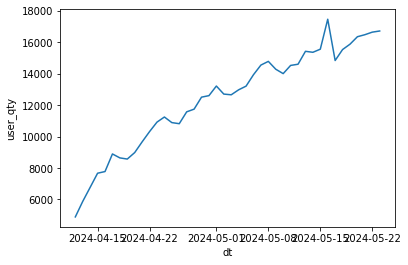

In [40]:
sns.lineplot(df_dau, x="dt", y="user_qty")

In [41]:
df_dau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_qty  42 non-null     uint64        
 1   dt        42 non-null     datetime64[ns]
dtypes: datetime64[ns](1), uint64(1)
memory usage: 800.0 bytes


In [42]:
# Изменим тип даты на строку
df_dau['dt'] = df_dau['dt'].astype(str)
df_dau = df_dau.set_index('dt')

In [43]:
# Построим модель для метрики DAU
impact = CausalImpact(data=df_dau, #данные
                      pre_period=["2024-04-12", "2024-05-16"], #период до события
                      post_period=["2024-05-17", "2024-05-23"], #период после события
                      model_args={"nseasons":7}) #сезонность по дням недели

2024-09-07 19:16:18.185798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:16:18.272142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:16:18.772910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:

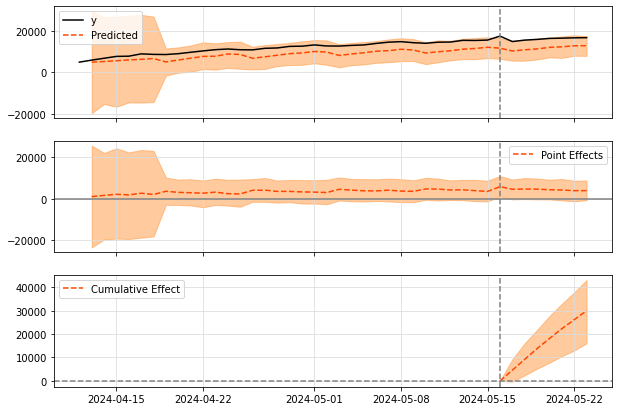

In [44]:
impact.plot()

In [45]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         11763.7 (974.77)   82345.9 (6823.39)
95% CI                    [9918.05, 13739.07][69426.32, 96173.51]

Absolute effect (s.d.)    4289.01 (974.77)   30023.1 (6823.39)
95% CI                    [2313.64, 6134.67] [16195.49, 42942.68]

Relative effect (s.d.)    36.46% (8.29%)     36.46% (8.29%)
95% CI                    [19.67%, 52.15%]   [19.67%, 52.15%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [46]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. By contrast, in the absence of an
intervention, we would have expected an average response of 11763.7.
The 95% interval of this counterfactual prediction is [9918.05, 13739.07].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 4289.01 with a 95% interval of
[2313.64, 6134.67]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 82345.9. The 95% interval of this prediction is [69426.32, 96173.51].


The above results are given in terms of absolute numbers. In relative
ter

#### Вывод:
Без флешмоба среднее значение лайков на пост прогнозируется около 11765, в то время как в действительности во время флешмоба среднее значение было около 16052. Вычитая прогнозное среднее значение из фактического получаем причинно-следственный эффект 4287. В относительных значениях переменная количества новых постов показала увеличение на ~36%.  
Полученный эффект, наблюдаемый в период флешмоба, является статистически значимым, p-value = 0.00. Вероятность получения такого эффекта случайным образом очень мала.

НО! Если посмотреть на период до флешмоба, то видно, что прогнозные значения систематически ниже фактических, такой же тренд сохраняется и после флешмоба.То есть разница +36% - это не результат флешмоба, а вероятная ошибка модели.

#### Попробуем добавить в модель ковариат - количество пользователей мессенджера

In [53]:
q_message_users = """
select countDistinct(user_id) as users, toDate(time) as dt
from simulator_20240520.message_actions
where dt between '2024-04-12' and '2024-05-23'
group by dt
"""

df_message_users = ph.read_clickhouse(q_message_users, connection=connection)

In [54]:
df_message_users.head()

,users,dt
0,546,2024-04-12
1,579,2024-04-13
2,798,2024-04-14
3,676,2024-04-15
4,594,2024-04-16


In [55]:
# Изменим тип даты на строку и установим дату как индекс 
#df_message_users['dt'] = df_message_users['dt'].astype(str)
df_message_users = df_message_users.set_index('dt')

In [56]:
# Проверим корреляцию двух величин
np.corrcoef(df_dau.user_qty, df_message_users.users)

array([[1.        , 0.78266637],
       [0.78266637, 1.        ]])

In [57]:
# Построим модель для метрики DAU с ковариатом (DAU в мессенджере):
impact_dau_2 = CausalImpact(data=pd.DataFrame({"y":df_dau['user_qty'], "X":df_message_users['users']}), #данные
                      pre_period=["2024-04-12", "2024-05-16"], #период до события
                      post_period=["2024-05-17", "2024-05-23"], #период после события
                      model_args={"nseasons":7}) #сезонность по дням недели

2024-09-07 19:34:12.379958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:34:12.467934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:34:12.482836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node InverseGamma/sample/PartitionedCall}}]]
2024-09-07 19:34:12.512574: I tensorflow/core/common_runtime/executor

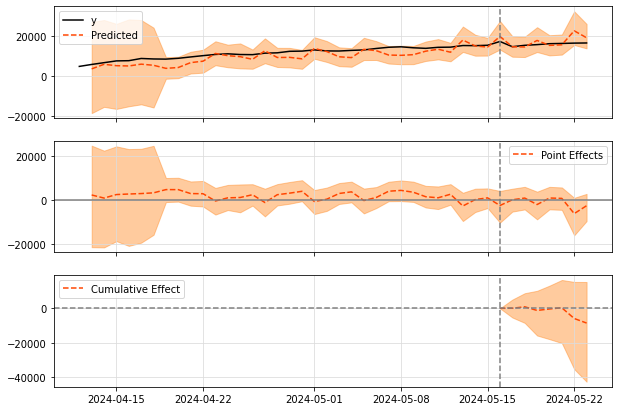

In [58]:
impact_dau_2.plot()

In [59]:
print(impact_dau_2.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         17269.53 (2018.89) 120886.69 (14132.21)
95% CI                    [13725.62, 21639.51][96079.31, 151476.56]

Absolute effect (s.d.)    -1216.81 (2018.89) -8517.69 (14132.21)
95% CI                    [-5586.79, 2327.1] [-39107.56, 16289.69]

Relative effect (s.d.)    -7.05% (11.69%)    -7.05% (11.69%)
95% CI                    [-32.35%, 13.48%]  [-32.35%, 13.48%]

Posterior tail-area probability p: 0.31
Posterior prob. of a causal effect: 69.33%

For more details run the command: print(impact.summary('report'))


#### Вывод:   
Без флешмоба среднее значение пользователей прогнозируется около 16474, в то время как в действительности во время флешмоба среднее значение было около 16052. Вычитая прогнозное среднее значение из фактического получаем причинно-следственный эффект -421. В относительных значениях переменная количества новых постов показала уменьшение на -2.56%.  
На графике видно, что значения эффекта колеблется около 0. Можно сделать вывод, что количество пользователей во время флешмоба не увеличилось.